In [1]:
# imports

import numpy as np
import pandas as pd 
from pathlib import Path

from collections import Counter

from sklearn.model_selection import train_test_split

from PIL import Image


import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import (Compose,
                                    RandomResizedCrop, 
                                    Resize,
                                    CenterCrop,
                                    RandomHorizontalFlip, 
                                    RandomVerticalFlip, 
                                    RandomPerspective, 
                                    RandomRotation,
                                    ColorJitter,
                                    Normalize,
                                    ToTensor
                                   )

import torchmetrics
from tqdm.notebook import tqdm
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import gc

# **Preparing Data**

In [2]:
#準備讀取資料
paths = []
labels = []
import os
        
ds_path = 'animals/'
for category in ['cats','dogs','panda']:
    for p in os.listdir(os.path.join(ds_path, category)):
        f = Path(os.path.join(ds_path,category, p))
        paths.append(f)
        labels.append(f.parent.stem)

In [3]:
Counter(labels)

Counter({'cats': 1000, 'dogs': 1000, 'panda': 1000})

In [4]:
# variation in image sizes

sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()
    
print(max(sizes), min(sizes))
del sizes

(1600, 1200) (55, 75)


In [5]:
#分割訓練與驗證集與測試集
x_train, x_test, y_train, y_test = train_test_split(paths, labels, test_size=0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=0)

## Augmentations

In [6]:
#基礎影像處理
basic_augmentations = Compose([
    Resize(224),
    CenterCrop(224),
    ToTensor()
])

basic_augmentations2 = Compose([
    RandomResizedCrop(224),
    ToTensor()
])

In [7]:
#訓練集與驗證與測試集影像處理
train_augmentations = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(1),
    RandomVerticalFlip(0.1),
    RandomPerspective(distortion_scale=0.2, p=0.2),
    RandomRotation(15),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
val_augmentations = Compose([
    Resize(384),
    CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
test_augmentations = Compose([
    Resize(384),
    CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [8]:
#Dataloader
class AnimalDataset:
    
    def __init__(self, paths, labels, augmentations):
        self.paths = paths
        self.labels = labels
        self.classes = {
            'panda': 0,
            'dog': 1,
            'cat': 2
        }
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        
        sample = Image.open(self.paths[idx]).convert(mode="RGB")
        sample = self.augmentations(sample)
        
        label = self.labels[idx]
        if label == 'panda':
            label = 0
        elif label == 'dogs':
            label = 1
        elif label == 'cats':
            label = 2
        
        return (sample, torch.tensor(label, dtype=torch.long))

In [9]:
train_ds = AnimalDataset(x_train, y_train, train_augmentations)
val_ds = AnimalDataset(x_val, y_val, val_augmentations)
test_ds = AnimalDataset(x_test, y_test, test_augmentations)

# **Visualization**

In [10]:
plot_ds = AnimalDataset(x_train[:16], y_train[:16], basic_augmentations)

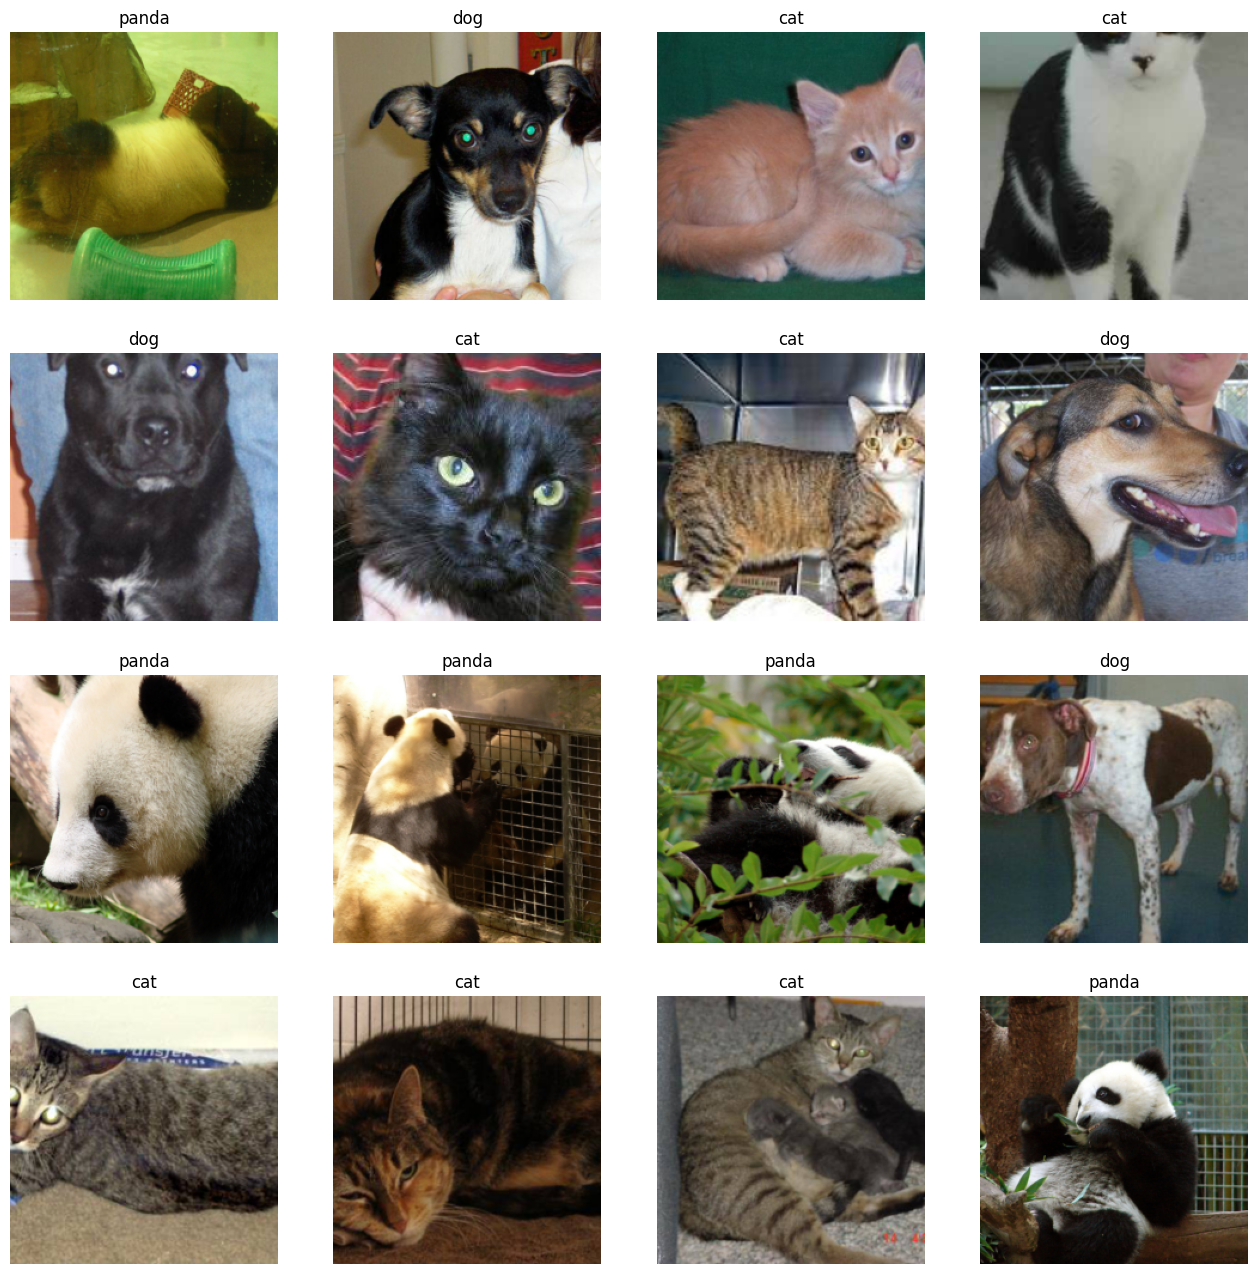

In [11]:
to_plot = []
classes = { 0: 'panda',
            1: 'dog',
            2: 'cat'
          }
for x,y in plot_ds:
    to_plot.append((x,y))
    
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(16,16))
for i in range(1,17):
    img = to_plot[i-1][0].permute(1,2,0)
    label = classes[(to_plot[i-1][1]).item()]
    figure.add_subplot(4,4,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

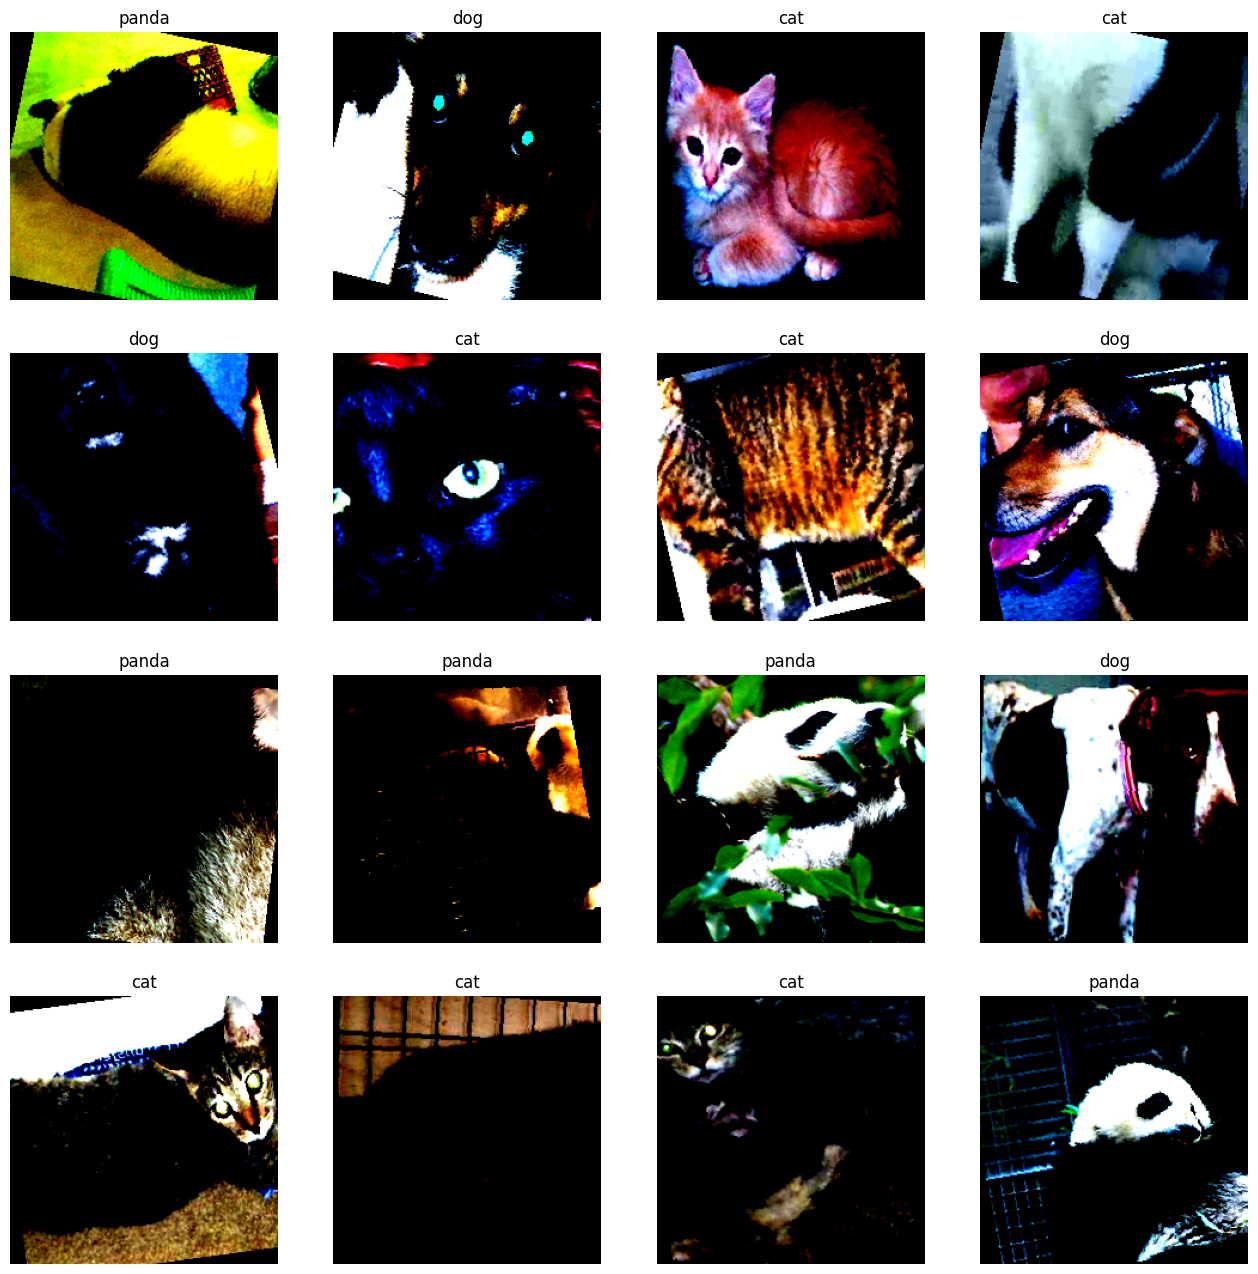

In [12]:
plot_ds_augmented = [train_ds[i] for i in range(16)]

figure = plt.figure(figsize=(16,16))
for i in range(1,17):
    img = plot_ds_augmented[i-1][0].permute(1,2,0)
    label = classes[(to_plot[i-1][1]).item()]
    figure.add_subplot(4,4,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

## Dataloaders

In [13]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, num_workers=0, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, num_workers=0, shuffle=True)

In [14]:
len(train_loader), len(val_loader), len(test_loader)

(38, 5, 5)

# **Model** 

In [15]:
#baseline模型backbone有4層，head由Flatten、AdaptiveAvgPool1d、Linear組成
class CNNModel(nn.Module):
    
    def __init__(self, in_features=3, num_classes=3):
        self.in_features = in_features
        self.num_classes = num_classes
        
        super(CNNModel, self).__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv2d(self.in_features,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128,256,3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            
            nn.Dropout2d(0.5)
        )
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.AdaptiveAvgPool1d(256),
            nn.Linear(256,self.num_classes)
        )

    def forward(self,x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [16]:
print(CNNModel())

CNNModel(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.5, inplace=False)
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): AdaptiveAvgPool1d(output

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Training**

在初始化方法中，訓練器接受了模型、數據加載器和配置參數作為輸入。它會將模型、數據加載器和配置參數保存下來，並初始化了損失函數、優化器和學習率調整器（如果啟用了調度器），以及一系列的指標評估器用於評估模型的性能。

訓練過程分為兩個主要步驟：訓練一個 epoch 和驗證一個 epoch。在訓練一個 epoch 的過程中，模型被設置為訓練模式，遍歷訓練數據集，計算並更新損失，同時記錄訓練指標的變化。在驗證一個 epoch 的過程中，模型被設置為評估模式，遍歷驗證數據集，計算並記錄驗證損失和指標。

在每個 epoch 結束後，會根據記錄的損失和指標打印出訓練和驗證的表現。同時，如果驗證準確率優於之前記錄的最佳準確率，則更新最佳驗證準確率和對應的 epoch。

訓練過程中會在每個 epoch 的開始和結束時清理內存，以避免內存泄漏和減少內存使用。

In [18]:
class Trainer:
    
    def __init__(self, model, loaders, config):
        self.model = model
        self.train_loader, self.val_loader = loaders
        self.config = config
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.optim1 = torch.optim.SGD(self.model.parameters(), 
                                     lr=self.config['lr'], 
                                     momentum=self.config['sgd_momentum']
                                    )
        self.optim2 = torch.optim.Adam(self.model.parameters(),
                                       lr = self.config['lr']
                                      )
        self.optim3 = torch.optim.AdamW(self.model.parameters(),
                                        lr=self.config['lr'],
#                                         default weight decay: 1e-3
                                       )
        
        
        self.optim = self.optim3
        
        if self.config['scheduler']:
            self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optim,
                                                             step_size=self.config['sch_step_size'], 
                                                             gamma=self.config['sch_gamma']
                                                            )
            
            
        metrics = torchmetrics.MetricCollection([
            torchmetrics.Accuracy(average='macro', num_classes=3, task='multiclass'),
            torchmetrics.Precision(average='macro', num_classes=3, task='multiclass'),
            torchmetrics.Recall(average='macro', num_classes=3, task='multiclass'),
            torchmetrics.F1Score(average='macro', num_classes=3, task='multiclass')
        ]).to(self.config['device'])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')

        self.best_val_accuracy = 0
        self.best_model_state = None
        
        self.train_logs = []
        self.val_logs = []
        
    def logger(self, epoch, metrics, loss, mode):
        metrics = {metric: metrics[metric].cpu().item() for metric in metrics}
        log = {f'epoch_{epoch-1}': {'loss': loss, 'metrics': metrics}}
        
        if mode == 'train':
            self.train_logs.append(log)
        else:
            self.val_logs.append(log)
            val_acc = metrics['val_MulticlassAccuracy']
            if val_acc > self.best_val_accuracy:
                self.best_val_accuracy = val_acc
                self.best_model_state = self.model.state_dict()
            
    def print_per_epoch(self, epoch):
        print(f"\n\n{'-'*30}EPOCH {epoch}/{self.config['epochs']}{'-'*30}")
        epoch = epoch-1 
        train_loss = self.train_logs[epoch][f'epoch_{epoch}']['loss']
        train_acc = self.train_logs[epoch][f'epoch_{epoch}']['metrics']['train_MulticlassAccuracy']
        val_loss = self.val_logs[epoch][f'epoch_{epoch}']['loss']
        val_acc = self.val_logs[epoch][f'epoch_{epoch}']['metrics']['val_MulticlassAccuracy']
        print(f"Train -> LOSS: {train_loss} | ACC: {train_acc}")
        print(f"Validation -> LOSS: {val_loss} | ACC: {val_acc}\n\n\n")
        
    def train_one_epoch(self, epoch):
        
        running_loss = 0
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        for x,y in progress:
            
            self.optim.zero_grad()
        
            x = x.to(self.config['device'])
            y = y.to(self.config['device'])
            
            preds = self.model(x)
            
            loss = self.loss_fn(preds, y)
            running_loss += loss.item()
            loss.backward()
            self.optim.step()
            
            self.train_metrics(torch.argmax(preds, dim=1), y)
            progress.set_description(f"Train Loss Step: {loss.item():.3f}")
            
            del x,y,preds,loss
            
        if self.config['scheduler']:
            self.scheduler.step()
            
        metrics = self.train_metrics.compute()
        train_loss = running_loss / len(self.train_loader)
        
        self.logger(epoch,metrics,train_loss,'train')

        del metrics
        
    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        running_loss = 0
        progress = tqdm(self.val_loader, total=len(self.val_loader))
        for x, y in progress:
            x = x.to(self.config['device'])
            y = y.to(self.config['device'])
            preds = self.model(x)
            loss = self.loss_fn(preds, y)
            running_loss += loss.item()
            
            self.val_metrics(torch.argmax(preds, dim=1), y)
            progress.set_description(f"Validation Loss Step: {loss.item():.3f}")
        
        metrics = self.val_metrics.compute()
        val_loss = running_loss / len(self.val_loader)
        self.logger(epoch, metrics, val_loss, 'val')
        
    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()
            
        
    def fit(self):
        
        fit_progress = tqdm(
            range(1, self.config['epochs']+1),
            leave = True,
            desc="Training..."
        )
        for epoch in fit_progress:
            
            self.model.train()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | training...")
            self.train_one_epoch(epoch)
            self.clear()
            
            self.model.eval()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | validating...")
            self.valid_one_epoch(epoch)
            self.clear()
            
            # reset metrics
            self.train_metrics.reset()
            self.val_metrics.reset()
            
            # print metrics
            self.print_per_epoch(epoch)
        self.model.load_state_dict(self.best_model_state)  # Load the best model state
        return self.model  # Return the best model

In [19]:
gc.collect()
torch.cuda.empty_cache()

# **Trainer with scheduler**

In [20]:
config = {
    'lr': 1e-3,
    'epochs': 20,
    'sgd_momentum': 0.8,
    'scheduler': True,
    'sch_step_size': 2,
    'sch_gamma': 0.2,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}
print("training on:",config['device'])
model = CNNModel().to(device=config['device'])
trainer = Trainer(model, (train_loader, val_loader), config)

training on: cuda


In [21]:
cnnmodel = trainer.fit()

Training...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 1/20------------------------------
Train -> LOSS: 0.8776350131160334 | ACC: 0.5550047755241394
Validation -> LOSS: 0.8059690713882446 | ACC: 0.645983874797821





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 2/20------------------------------
Train -> LOSS: 0.8121689197264219 | ACC: 0.60560542345047
Validation -> LOSS: 0.8081912636756897 | ACC: 0.6311661005020142





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 3/20------------------------------
Train -> LOSS: 0.7652076702368887 | ACC: 0.6265533566474915
Validation -> LOSS: 0.7474973201751709 | ACC: 0.6691722869873047





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 4/20------------------------------
Train -> LOSS: 0.7447060895593542 | ACC: 0.6419156193733215
Validation -> LOSS: 0.7362027764320374 | ACC: 0.683731198310852





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 5/20------------------------------
Train -> LOSS: 0.7218036181048343 | ACC: 0.6571813225746155
Validation -> LOSS: 0.7028169870376587 | ACC: 0.7229910492897034





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 6/20------------------------------
Train -> LOSS: 0.7065129923193079 | ACC: 0.6563438773155212
Validation -> LOSS: 0.7017476797103882 | ACC: 0.7091428637504578





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 7/20------------------------------
Train -> LOSS: 0.7179005538162432 | ACC: 0.6634422540664673
Validation -> LOSS: 0.6990791916847229 | ACC: 0.708314061164856





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 8/20------------------------------
Train -> LOSS: 0.6989676152404986 | ACC: 0.6637915968894958
Validation -> LOSS: 0.6958657741546631 | ACC: 0.7089893817901611





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 9/20------------------------------
Train -> LOSS: 0.6954212486743927 | ACC: 0.6589914560317993
Validation -> LOSS: 0.7072218894958496 | ACC: 0.7095240950584412





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 10/20------------------------------
Train -> LOSS: 0.7042068635162554 | ACC: 0.6640737652778625
Validation -> LOSS: 0.6975386619567872 | ACC: 0.7238197922706604





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 11/20------------------------------
Train -> LOSS: 0.7163369388956773 | ACC: 0.6542232036590576
Validation -> LOSS: 0.7065375208854675 | ACC: 0.7018415331840515





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 12/20------------------------------
Train -> LOSS: 0.700488479513871 | ACC: 0.6757413744926453
Validation -> LOSS: 0.6998275279998779 | ACC: 0.7105371356010437





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 13/20------------------------------
Train -> LOSS: 0.7076205203407689 | ACC: 0.6566623449325562
Validation -> LOSS: 0.7079964280128479 | ACC: 0.7244952917098999





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 14/20------------------------------
Train -> LOSS: 0.7062012270877236 | ACC: 0.6733351349830627
Validation -> LOSS: 0.7039812564849853 | ACC: 0.7205835580825806





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 15/20------------------------------
Train -> LOSS: 0.6901121233638964 | ACC: 0.6691703796386719
Validation -> LOSS: 0.707436466217041 | ACC: 0.7141110897064209





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 16/20------------------------------
Train -> LOSS: 0.7109236356459165 | ACC: 0.6552218198776245
Validation -> LOSS: 0.7022692680358886 | ACC: 0.7105371356010437





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 17/20------------------------------
Train -> LOSS: 0.69765337046824 | ACC: 0.6689594388008118
Validation -> LOSS: 0.6986197113990784 | ACC: 0.7212590575218201





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 18/20------------------------------
Train -> LOSS: 0.7153630931126443 | ACC: 0.652930498123169
Validation -> LOSS: 0.7125457286834717 | ACC: 0.7130544185638428





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 19/20------------------------------
Train -> LOSS: 0.7113185352400729 | ACC: 0.6492036581039429
Validation -> LOSS: 0.7014805793762207 | ACC: 0.7186981439590454





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 20/20------------------------------
Train -> LOSS: 0.7195975686374464 | ACC: 0.660945475101471
Validation -> LOSS: 0.6947550177574158 | ACC: 0.7215967178344727





In [22]:
# trainer.train_logs

In [23]:
# trainer.val_logs

# **PLOTS**

In [24]:
#繪製ACC、LOSS、Precison、Recall、F1-score
def get_metric(metrics, mode, metric):
    values = []
    for i in range(config['epochs']):
        base = metrics[i][f'epoch_{i}']
        if metric == 'loss':
            value = base['loss']
        else:
            value = base['metrics'][f'{mode}_Multiclass{metric}']
        values.append(value)
        
    return values

# 計算混淆矩陣、繪製混淆矩陣
def get_cm(model, test_loader):
    y_true, y_pred = [], []
    progress = tqdm(test_loader, total=len(test_loader))
    for x, y in progress:
        x = x.to(config['device'])
        y = y.to(config['device'])
        preds = model(x)
        y_true.append(y.cpu().detach().numpy())
        y_pred.append(torch.argmax(preds, dim=1).cpu().detach().numpy())
    
    y_true = [i for item in y_true for i in item]
    y_pred = [i for item in y_pred for i in item]
    print("Model Test ACC:",accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## confusion matrix

  0%|          | 0/5 [00:00<?, ?it/s]

Model Test ACC: 0.6833333333333333


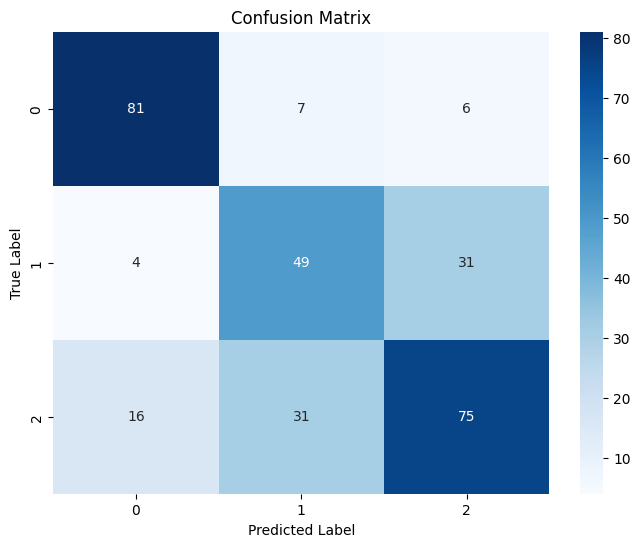

In [25]:
get_cm(cnnmodel, test_loader)

## Loss Plot

Text(0.5, 1.0, 'Loss')

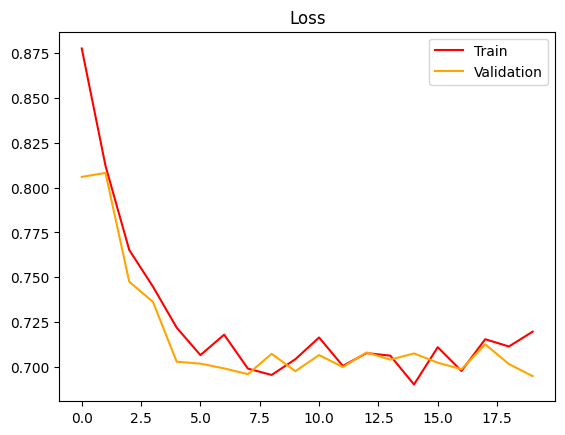

In [26]:
plt.plot(get_metric(trainer.train_logs,'train','loss'), color='red')
plt.plot(get_metric(trainer.val_logs,'val','loss'), color='orange')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.title('Loss')

## Accuracy Plot

Text(0.5, 1.0, 'Accuracy')

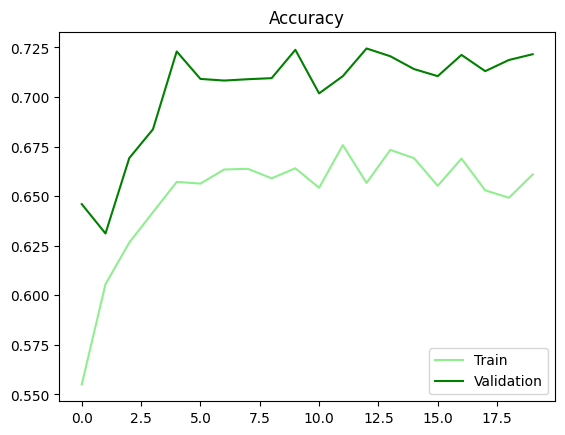

In [27]:
plt.plot(get_metric(trainer.train_logs,'train','Accuracy'), color='lightgreen')
plt.plot(get_metric(trainer.val_logs,'val','Accuracy'), color='green')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Accuracy')

## Precision Plot

Text(0.5, 1.0, 'Precision')

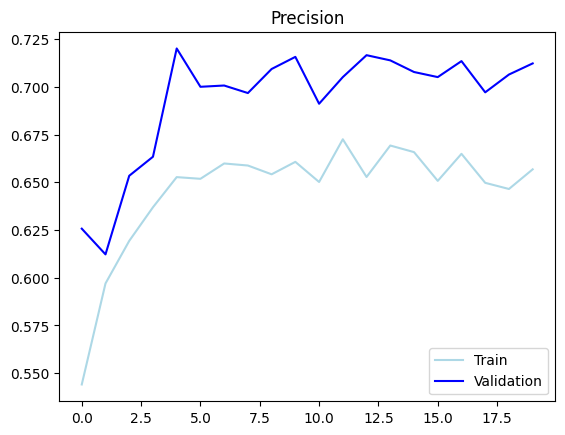

In [28]:
plt.plot(get_metric(trainer.train_logs,'train','Precision'), color='lightblue')
plt.plot(get_metric(trainer.val_logs,'val','Precision'), color='blue')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Precision')

## Recall Plot

Text(0.5, 1.0, 'Recall')

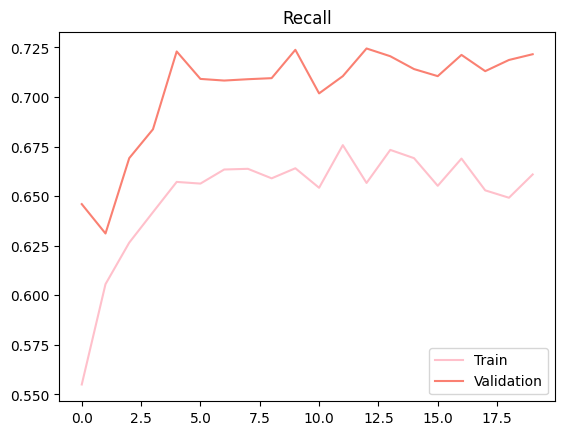

In [29]:
plt.plot(get_metric(trainer.train_logs,'train','Recall'), color='pink')
plt.plot(get_metric(trainer.val_logs,'val','Recall'), color='salmon')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Recall')

## F1Score Plot

Text(0.5, 1.0, 'F1Score')

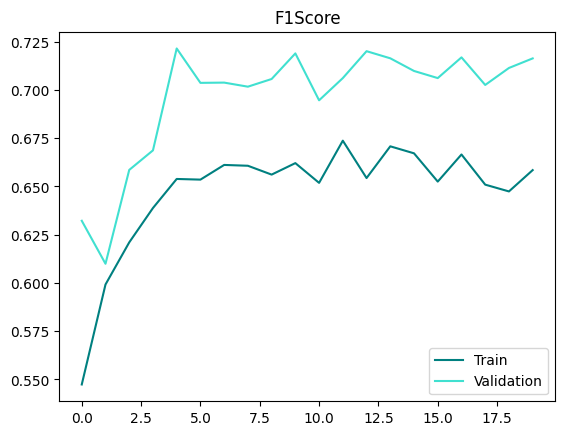

In [30]:
plt.plot(get_metric(trainer.train_logs,'train','F1Score'), color='teal')
plt.plot(get_metric(trainer.val_logs,'val','F1Score'), color='turquoise')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('F1Score')

## 模型修改

In [31]:
#優化模型CNNModel backbone有4層、DeepCNNModel改為5層並且輸出512 channel，head一樣由Flatten、AdaptiveAvgPool1d、Linear組成
import torch.nn as nn
import torch.nn.functional as F

class DeepCNNModel(nn.Module):
    
    def __init__(self, in_features=3, num_classes=3):
        self.in_features = in_features
        self.num_classes = num_classes
        
        super(DeepCNNModel, self).__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv2d(self.in_features,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128,256,3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),

            nn.Conv2d(256,512,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Dropout2d(0.5)
        )
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.AdaptiveAvgPool1d(512),
            nn.Linear(512,self.num_classes)
        )

    def forward(self,x):
        x = self.backbone(x)
        x = self.head(x)
        return x


In [32]:
print(DeepCNNModel())

DeepCNNModel(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [33]:
gc.collect()
torch.cuda.empty_cache()

In [34]:
config = {
    'lr': 1e-3,
    'epochs': 20,
    'sgd_momentum': 0.8,
    'scheduler': True,
    'sch_step_size': 2,
    'sch_gamma': 0.2,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}
print("training on:",config['device'])
model = DeepCNNModel().to(device=config['device'])
trainer = Trainer(model, (train_loader, val_loader), config)

training on: cuda


In [35]:
deepcnnmodel = trainer.fit()

Training...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 1/20------------------------------
Train -> LOSS: 1.1013186370071613 | ACC: 0.5076408982276917
Validation -> LOSS: 1.0693699359893798 | ACC: 0.530375063419342





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 2/20------------------------------
Train -> LOSS: 0.8405611499359733 | ACC: 0.593044102191925
Validation -> LOSS: 0.7620284795761109 | ACC: 0.6185052990913391





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 3/20------------------------------
Train -> LOSS: 0.7716569947568994 | ACC: 0.620532751083374
Validation -> LOSS: 0.7311148643493652 | ACC: 0.6606608629226685





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 4/20------------------------------
Train -> LOSS: 0.7500509635398263 | ACC: 0.6212731003761292
Validation -> LOSS: 0.6814453125 | ACC: 0.6904007196426392





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 5/20------------------------------
Train -> LOSS: 0.6961511655857688 | ACC: 0.647456705570221
Validation -> LOSS: 0.6980984210968018 | ACC: 0.6914220452308655





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 6/20------------------------------
Train -> LOSS: 0.7158603213335338 | ACC: 0.6429699659347534
Validation -> LOSS: 0.6777955293655396 | ACC: 0.6674093008041382





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 7/20------------------------------
Train -> LOSS: 0.6956426030711124 | ACC: 0.6595024466514587
Validation -> LOSS: 0.6865985035896301 | ACC: 0.6663962006568909





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 8/20------------------------------
Train -> LOSS: 0.685263737251884 | ACC: 0.6663898825645447
Validation -> LOSS: 0.6731629014015198 | ACC: 0.6717022061347961





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 9/20------------------------------
Train -> LOSS: 0.7070838212966919 | ACC: 0.6498633623123169
Validation -> LOSS: 0.6814697861671448 | ACC: 0.6689571142196655





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 10/20------------------------------
Train -> LOSS: 0.6941548774116918 | ACC: 0.6493837237358093
Validation -> LOSS: 0.6828021168708801 | ACC: 0.6602613925933838





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 11/20------------------------------
Train -> LOSS: 0.7155028754159024 | ACC: 0.6444492936134338
Validation -> LOSS: 0.674990963935852 | ACC: 0.6648920774459839





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 12/20------------------------------
Train -> LOSS: 0.6899670691866624 | ACC: 0.6518974900245667
Validation -> LOSS: 0.6752652645111084 | ACC: 0.6684659719467163





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 13/20------------------------------
Train -> LOSS: 0.7033367611859974 | ACC: 0.6508018374443054
Validation -> LOSS: 0.6684507012367249 | ACC: 0.6652297377586365





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 14/20------------------------------
Train -> LOSS: 0.7080573674879576 | ACC: 0.6449522972106934
Validation -> LOSS: 0.6781502604484558 | ACC: 0.6648920774459839





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 15/20------------------------------
Train -> LOSS: 0.7032712556813893 | ACC: 0.6438869833946228
Validation -> LOSS: 0.675575566291809 | ACC: 0.6689571142196655





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 16/20------------------------------
Train -> LOSS: 0.7062746725584331 | ACC: 0.6442378163337708
Validation -> LOSS: 0.6755142331123352 | ACC: 0.6692947745323181





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 17/20------------------------------
Train -> LOSS: 0.6893437975331357 | ACC: 0.6657276749610901
Validation -> LOSS: 0.6832194447517395 | ACC: 0.6648920774459839





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 18/20------------------------------
Train -> LOSS: 0.7113916309256303 | ACC: 0.6468968391418457
Validation -> LOSS: 0.6806283354759216 | ACC: 0.6660585403442383





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 19/20------------------------------
Train -> LOSS: 0.7060631497910148 | ACC: 0.6502953171730042
Validation -> LOSS: 0.6786072015762329 | ACC: 0.6602613925933838





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



------------------------------EPOCH 20/20------------------------------
Train -> LOSS: 0.6977810247948295 | ACC: 0.6486398577690125
Validation -> LOSS: 0.6809838652610779 | ACC: 0.6660585403442383





## confusion matrix

  0%|          | 0/5 [00:00<?, ?it/s]

Model Test ACC: 0.7333333333333333


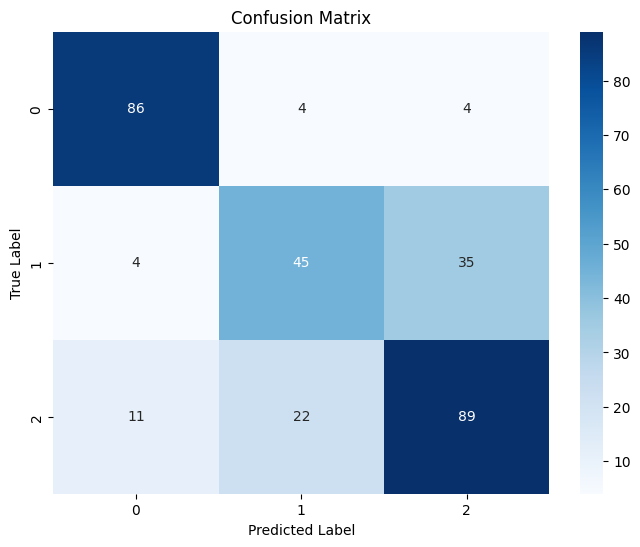

In [36]:
get_cm(deepcnnmodel, test_loader)

## Loss Plot

Text(0.5, 1.0, 'Loss')

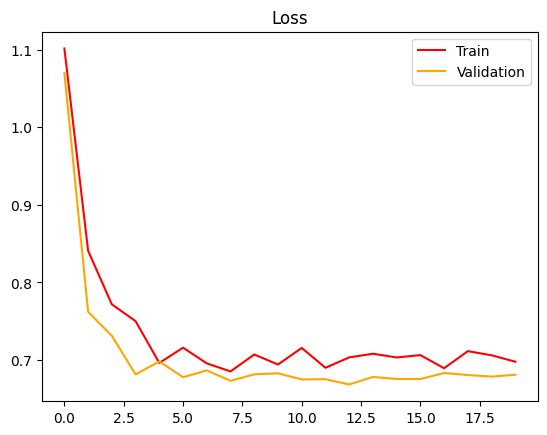

In [37]:
plt.plot(get_metric(trainer.train_logs,'train','loss'), color='red')
plt.plot(get_metric(trainer.val_logs,'val','loss'), color='orange')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.title('Loss')

## Accuracy Plot

Text(0.5, 1.0, 'Accuracy')

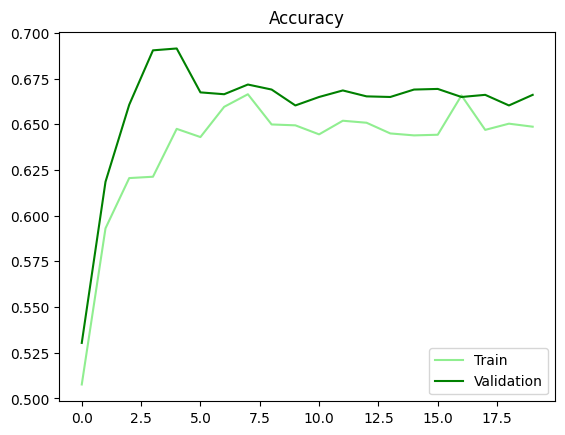

In [38]:
plt.plot(get_metric(trainer.train_logs,'train','Accuracy'), color='lightgreen')
plt.plot(get_metric(trainer.val_logs,'val','Accuracy'), color='green')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Accuracy')

## Precision Plot

Text(0.5, 1.0, 'Precision')

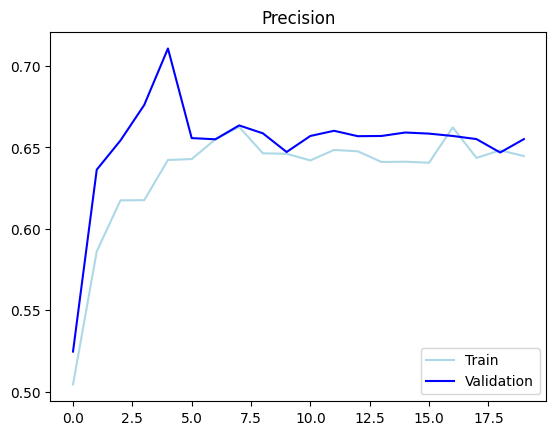

In [39]:
plt.plot(get_metric(trainer.train_logs,'train','Precision'), color='lightblue')
plt.plot(get_metric(trainer.val_logs,'val','Precision'), color='blue')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Precision')

## Recall Plot

Text(0.5, 1.0, 'Recall')

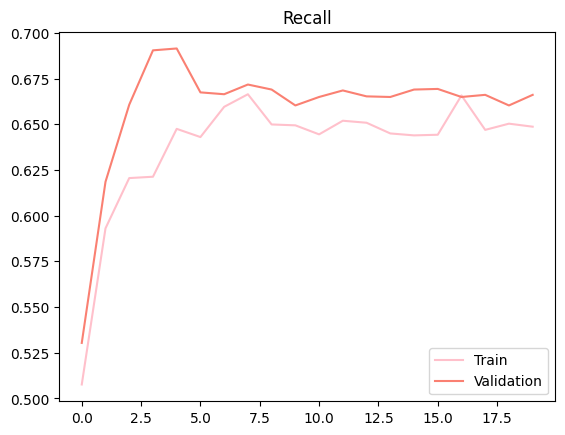

In [40]:
plt.plot(get_metric(trainer.train_logs,'train','Recall'), color='pink')
plt.plot(get_metric(trainer.val_logs,'val','Recall'), color='salmon')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Recall')

## F1Score Plot

Text(0.5, 1.0, 'F1Score')

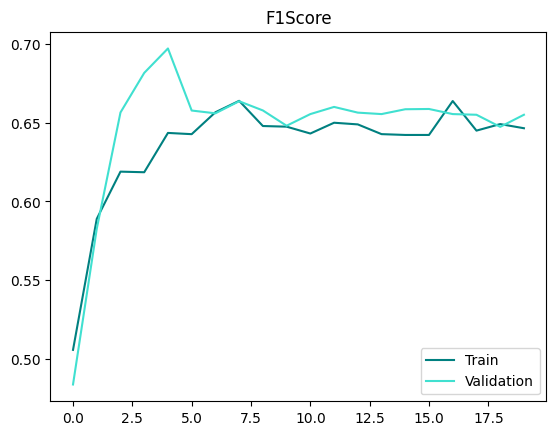

In [41]:
plt.plot(get_metric(trainer.train_logs,'train','F1Score'), color='teal')
plt.plot(get_metric(trainer.val_logs,'val','F1Score'), color='turquoise')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('F1Score')